In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
import tensorflow as tf 
tf.test.gpu_device_name() 

'/device:GPU:0'

In [ ]:
from tensorflow import keras

from keras.layers import Input, Dense, concatenate
from keras.models import Model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
from keras.utils import to_categorical

Using TensorFlow backend.


In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
import numpy as np

class FuzzyLayer(Layer):

    def __init__(self, 
                 output_dim, 
                 initializer_centers=None,
                 initializer_sigmas=None, 
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        self.output_dim = output_dim
        self.initializer_centers = initializer_centers
        self.initializer_sigmas = initializer_sigmas
        super(FuzzyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_dimensions = list(input_shape)[:-1:-1]
        self.c = self.add_weight(name='c', 
                                 shape=(input_shape[-1], self.output_dim),
                                 initializer= self.initializer_centers if self.initializer_centers is not None else 'uniform',
                                 trainable=True)
        self.a = self.add_weight(name='a', 
                                 shape=(input_shape[-1], self.output_dim),
                                 initializer=self.initializer_sigmas if self.initializer_sigmas is not None else 'ones',
                                 trainable=True)
        super(FuzzyLayer, self).build(input_shape)  

    def call(self, x):
        
        aligned_x = K.repeat_elements(K.expand_dims(x, axis = -1), self.output_dim, -1)
        aligned_c = self.c
        aligned_a = self.a
        for dim in self.input_dimensions:
            aligned_c = K.repeat_elements(K.expand_dims(aligned_c, 0), dim, 0)
            aligned_a = K.repeat_elements(K.expand_dims(aligned_a, 0), dim, 0)

        xc = K.exp(-K.sum(K.square((aligned_x - aligned_c) / (2 * aligned_a)), axis=-2, keepdims=False))
        #sums = K.sum(xc,axis=-1,keepdims=True)
        #less = K.ones_like(sums) * K.epsilon()
        return xc# xc / K.maximum(sums, less)
        
    def compute_output_shape(self, input_shape):
        return tuple(input_shape[:-1]) + (self.output_dim,)

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
import numpy as np
# https://github.com/kenoma/KerasFuzzy

class DefuzzyLayer(Layer):

    def __init__(self,
                 output_dim,
                 initializer_rules_outcome=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        self.output_dim = output_dim
        self.initializer_rules_outcome = initializer_rules_outcome
        super(DefuzzyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_dimensions = list(input_shape)[:-1:-1]
        self.rules_outcome = self.add_weight(name='rules_outcome',
                                             shape=(input_shape[1], self.output_dim),
                                             initializer=self.initializer_rules_outcome if self.initializer_rules_outcome is not None else 'uniform',
                                             trainable=True)

        super(DefuzzyLayer, self).build(input_shape)

    def call(self, x):
        aligned_x = K.repeat_elements(K.expand_dims(x, axis=-1), self.output_dim, -1)
        aligned_rules_outcome = self.rules_outcome
        for dim in self.input_dimensions:
            aligned_rules_outcome = K.repeat_elements(K.expand_dims(aligned_rules_outcome, 0), dim, 0)

        xc = K.sum((aligned_x * aligned_rules_outcome), axis=-2, keepdims=False)
        return xc

    def compute_output_shape(self, input_shape):
        return tuple(input_shape[:-1]) + (self.output_dim,)

In [ ]:
# -*- coding: utf-8 -*-
"""
 
Database:
https://www.kaggle.com/c/data-science-bowl-2018/data
 
Source: Kaggle 2018 Competition
 
Created on Tue Mar 31 03:30:25 2020
 
@author: Todor Slavov
@author: Mark Kirchev
 
"""
 
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm
 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
 
seed = 42
np.random.seed = seed
 
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_CHANNELS = 3






inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
      
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
 
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

fuzzy_layer = FuzzyLayer(128)
last_layer = fuzzy_layer(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(last_layer)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

 
print("Bukvalno az")





 
TRAIN_PATH = '/content/drive/My Drive/CN/stage1-train/'
TEST_PATH = '/content/drive/My Drive/CN/stage1-test/'
 
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
 
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
 
print("Resizing training images and masks")
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
 
    Y_train[n] = mask
 
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print("Resizing test images")
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
 
    #print(img.shape())
 
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
 
print("Done!")
 
# Building the model
 




checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)
 
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')]
 
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

# model.save("Toshko.h5")
 
idx = random.randint(0, len(X_train))
 
preds_train = model.predict(X_train[:int(X_train.shape[0] * 0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0] * 0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)
 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
 
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0] * 0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0] * 0.9):]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

# /content/drive/My Drive/Colab Notebooks/Kaggle 2018 Dataset/stage1_test/0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac/images/0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac.png

  0%|          | 0/40 [00:00<?, ?it/s]

(512, 512, 3)
Resizing training images and masks


  0%|          | 0/45 [00:00<?, ?it/s]

Resizing test images


100%|██████████| 45/45 [00:30<00:00,  1.48it/s]


Done!
Epoch 1/25
3/3 [==============================] - 59s 20s/step - loss: 0.4025 - accuracy: 0.8651 - val_loss: 0.4278 - val_accuracy: 0.8719
Epoch 2/25
3/3 [==============================] - 59s 20s/step - loss: 0.3784 - accuracy: 0.8651 - val_loss: 0.4127 - val_accuracy: 0.8719
Epoch 3/25
3/3 [==============================] - 59s 20s/step - loss: 0.3875 - accuracy: 0.8651 - val_loss: 0.4081 - val_accuracy: 0.8719
Epoch 4/25
3/3 [==============================] - 59s 20s/step - loss: 0.3728 - accuracy: 0.8651 - val_loss: 0.3969 - val_accuracy: 0.8719
Epoch 5/25
3/3 [==============================] - 61s 20s/step - loss: 0.3578 - accuracy: 0.8651 - val_loss: 0.3871 - val_accuracy: 0.8719
Epoch 6/25
3/3 [==============================] - 61s 20s/step - loss: 0.3485 - accuracy: 0.8651 - val_loss: 0.4056 - val_accuracy: 0.8719
Epoch 7/25
3/3 [==============================] - 60s 20s/step - loss: 0.3624 - accuracy: 0.8651 - val_loss: 0.3864 - val_accuracy: 0.8719
Epoch 8/25
3/3 [=====

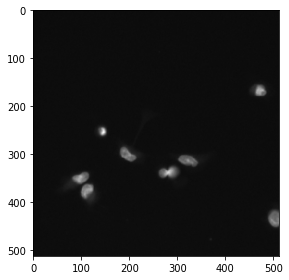


 
 our initial prediction of the pic: 


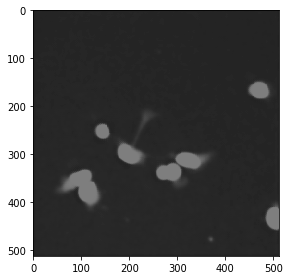


 
 bitmask of prediction of the pic: 


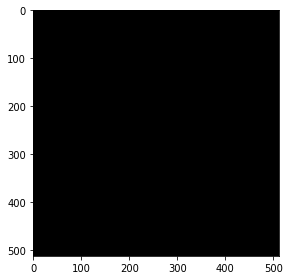

<class 'numpy.float32'>

 
 normalized values of the pic(spred out): 


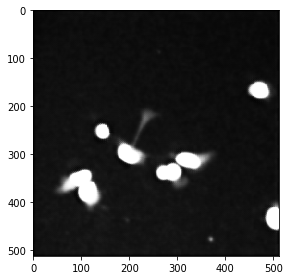


 
 bitmask of normalized pic: 


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


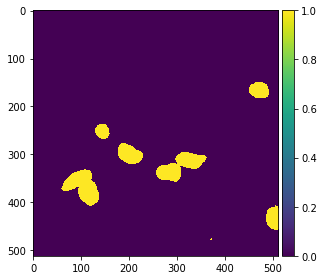

'\nidx = random.randint(0, len(X_train))\n\npreds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)\npreds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)\npreds_test = model.predict(X_test, verbose=1)\n\n \npreds_train_t = (preds_train > 0.5).astype(np.uint8)\npreds_val_t = (preds_val > 0.5).astype(np.uint8)\npreds_test_t = (preds_test > 0.5).astype(np.uint8)\n\n\n# Perform a sanity check on some random training samples\nix = random.randint(0, len(preds_train_t))\nimshow(X_train[ix])\nplt.show()\nimshow(np.squeeze(Y_train[ix]))\nplt.show()\nimshow(np.squeeze(preds_train_t[ix]))\nplt.show()\n\n# Perform a sanity check on some random validation samples\nix = random.randint(0, len(preds_val_t))\nimshow(X_train[int(X_train.shape[0]*0.9):][ix])\nplt.show()\nimshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))\nplt.show()\nimshow(np.squeeze(preds_val_t[ix]))\nplt.show()\n'

In [ ]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 42
np.random.seed = seed

IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

TRAIN_PATH = '/content/drive/My Drive/Colab Notebooks/Kaggle 2018 Dataset/stage1_train_little/'
TEST_PATH = '/content/drive/My Drive/Colab Notebooks/Kaggle 2018 Dataset/stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print(X_train[0, :, :, :].shape)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   

# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

#image_x = random.randint(0, len(train_ids))
#imshow(X_train[image_x])
#plt.show()
#imshow(np.squeeze(Y_train[image_x]))
#plt.show()




#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.05)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.05)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.15)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.1)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.1)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.05)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.05)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
fuzzy_layer = FuzzyLayer(2)
last_layer = fuzzy_layer(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(last_layer)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

################################
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

####################################

test = model.predict(X_test[:, :, :, :], verbose=1)
print("\n \n original pic: ")
imshow(X_test[5])
plt.show()
print("\n \n our initial prediction of the pic: ")
imshow(np.squeeze(test[5]))
plt.show()
test_b = (np.squeeze(test[5]) > 0.5).astype(np.uint8)
print("\n \n bitmask of prediction of the pic: ")
imshow(test_b)
plt.show()

test_norm = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)

test = np.squeeze(test[5])
print(type(test[0, 0]))
_min = test.min()
_max = test.max()
for x in range(test.shape[0]):
  for y in range(test.shape[1]):
    test_norm[x][y] = (test[x][y] - _min) / (_max - _min)


print("\n \n normalized values of the pic(spred out): ")
imshow(test_norm)
plt.show()

print("\n \n bitmask of normalized pic: ")
test_norm_b = (test_norm > 0.5).astype(np.uint8)
imshow(test_norm_b)
plt.show()

'''
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
'''